# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [2]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [3]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.07, 即時現金賣出: 29.74


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [4]:
cash_buy_list = []
cash_sell_list= []
currency_list = []
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
for rate in rate_table:
    #print(rate)
    prices = rate.find_all("td")
    #print(prices[1].text)
    cash_buy_list.append(prices[1].text)
    #print(prices[2].text)
    cash_sell_list.append(prices[2].text)

    currency_name = rate.find_all(class_="visible-phone print_hide")
    #print(currency_name[1].text.strip())
    currency_list.append(currency_name[1].text.strip())

df = pd.DataFrame()
df["貨幣"] = currency_list
df["現金買入"] = cash_buy_list
df["現金買出"] = cash_sell_list
df

,貨幣,現金買入,現金買出
0,美金 (USD),29.07,29.74
1,港幣 (HKD),3.646,3.85
2,英鎊 (GBP),36.09,38.21
3,澳幣 (AUD),20.16,20.94
4,加拿大幣 (CAD),21.22,22.13
5,新加坡幣 (SGD),20.65,21.56
6,瑞士法郎 (CHF),30.55,31.75
7,日圓 (JPY),0.2664,0.2792
8,南非幣 (ZAR),-,-
9,瑞典幣 (SEK),2.83,3.35


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)

<div class="visible-phone print_hide">
                                美金 (USD)
                            </div>
<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/USD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/history/USD


<Figure size 720x576 with 0 Axes>

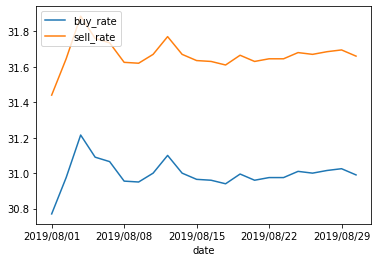

In [9]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類
print(currency)

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
print(history_link)
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁
print(history_rate_link)
#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

In [33]:
'''

  Your code here

'''

url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"

def get_history_rate_link(url):
    resp = requests.get(url)
    resp.encoding = 'utf-8'
    html = BeautifulSoup(resp.text, "lxml")
    rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
    #print(rate_table)

    history_rate_link_list = []


    for rate in rate_table:
        # 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
        currency = rate.find(name='div', attrs={'class':'visible-phone print_hide'})
        #print(currency.get_text().replace(" ", ""))  # 貨幣種類
        #print(currency)

        # 針對美金，找到其「歷史匯率」的首頁
        history_link = rate.find(name='td', attrs={'data-table':'歷史匯率'})
        #print(history_link)
        history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁
        #print(history_rate_link)
        history_rate_link_list.append(history_rate_link)

    return history_rate_link_list

In [42]:
#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料

def get_historical_plt(history_rate_link,timeframe):
    headers={
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36 Edg/83.0.478.56',

    }

    quote_history_url = history_rate_link.replace("history", "quote/"+timeframe)
    resp = requests.get(quote_history_url,headers = headers)
    resp.encoding = 'utf-8'
    history = BeautifulSoup(resp.text, "lxml")
    history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

    #
    # 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
    #
    date_history = list()
    history_buy = list()
    history_sell = list()

    for history_rate in history_table:
        # 擷取日期資料
        date_string = history_rate.a.get_text()
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
        date_history.append(date)  # 日期歷史資料

        history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
        history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

    # 將匯率資料建成dataframe形式
    HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                        'buy_rate':history_buy,
                                        'sell_rate':history_sell})

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

    # 畫出歷史匯率軌跡圖
    plt.figure(figsize=(15, 12))
    HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']]
    plt.legend(loc="upper left")
    plt.show()





這是USD在2020-06期間的數據圖：
這是HKD在2020-06期間的數據圖：
這是GBP在2020-06期間的數據圖：
這是AUD在2020-06期間的數據圖：
這是CAD在2020-06期間的數據圖：
這是SGD在2020-06期間的數據圖：
這是CHF在2020-06期間的數據圖：
這是JPY在2020-06期間的數據圖：
這是ZAR在2020-06期間的數據圖：
這是SEK在2020-06期間的數據圖：
這是NZD在2020-06期間的數據圖：
這是THB在2020-06期間的數據圖：
這是PHP在2020-06期間的數據圖：
這是IDR在2020-06期間的數據圖：
這是EUR在2020-06期間的數據圖：
這是KRW在2020-06期間的數據圖：
這是VND在2020-06期間的數據圖：
這是MYR在2020-06期間的數據圖：
這是CNY在2020-06期間的數據圖：


<Figure size 1080x864 with 0 Axes>

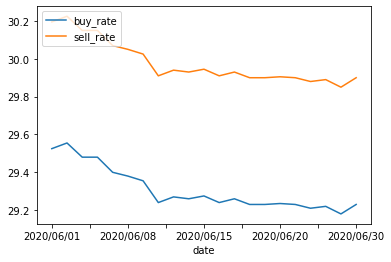

<Figure size 1080x864 with 0 Axes>

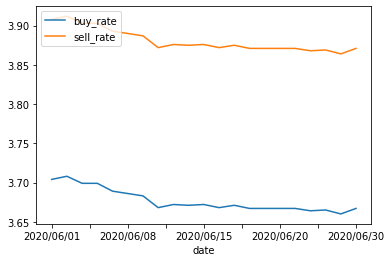

<Figure size 1080x864 with 0 Axes>

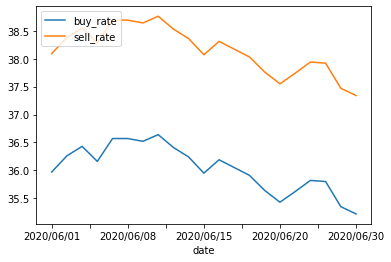

<Figure size 1080x864 with 0 Axes>

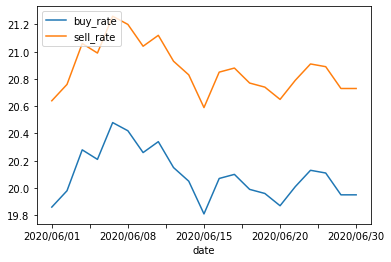

<Figure size 1080x864 with 0 Axes>

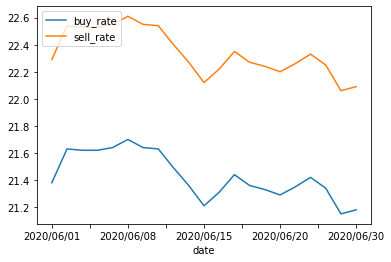

<Figure size 1080x864 with 0 Axes>

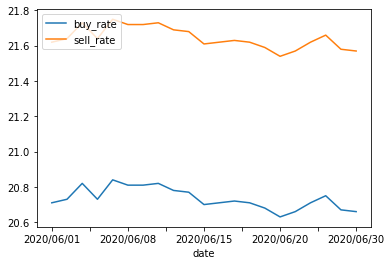

<Figure size 1080x864 with 0 Axes>

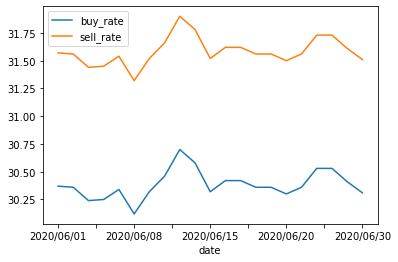

<Figure size 1080x864 with 0 Axes>

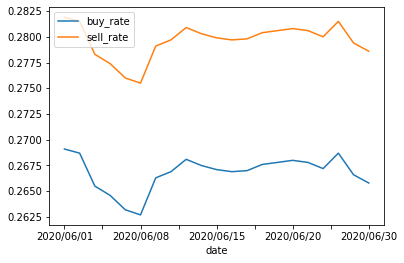

<Figure size 1080x864 with 0 Axes>

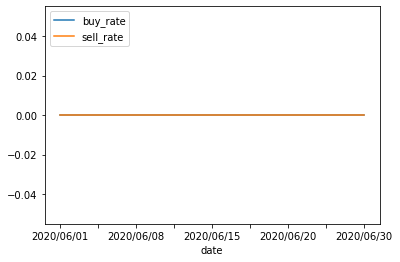

<Figure size 1080x864 with 0 Axes>

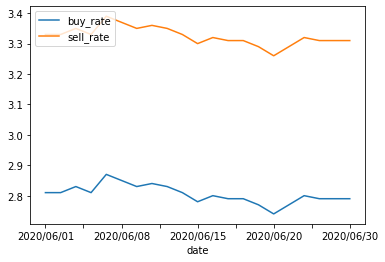

<Figure size 1080x864 with 0 Axes>

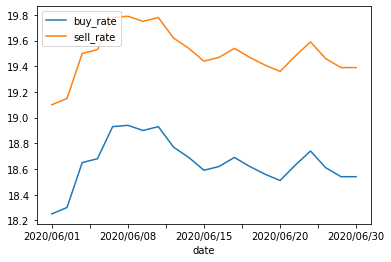

<Figure size 1080x864 with 0 Axes>

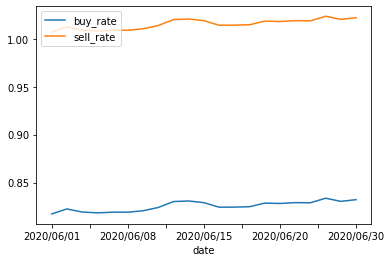

<Figure size 1080x864 with 0 Axes>

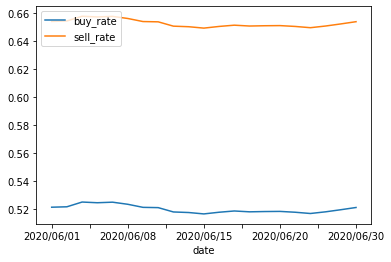

<Figure size 1080x864 with 0 Axes>

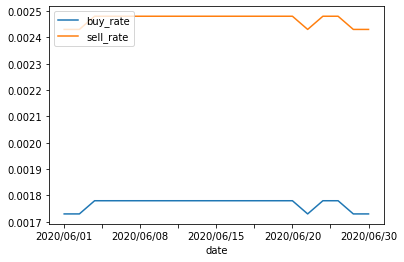

<Figure size 1080x864 with 0 Axes>

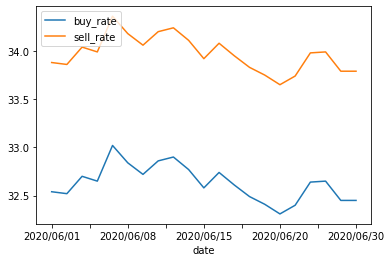

<Figure size 1080x864 with 0 Axes>

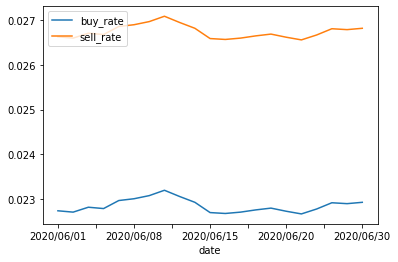

<Figure size 1080x864 with 0 Axes>

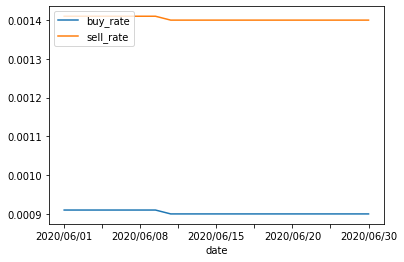

<Figure size 1080x864 with 0 Axes>

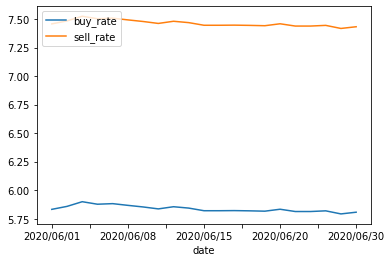

<Figure size 1080x864 with 0 Axes>

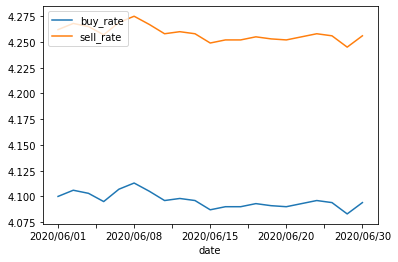

In [43]:
#取得全部貨幣歷史連結

url_list = get_history_rate_link(url)
#print(url_list)
timeframe="2020-06"
for ul in url_list:
    currency_name = ul.split('/')[-1]
    print(f"這是{currency_name}在{timeframe}期間的數據圖：")
    get_historical_plt(ul,timeframe)